In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, roc_auc_score
from tqdm import tqdm
import shap
shap.initjs()
plt.rcParams["figure.figsize"] = (12,8)

### Dataset

In [2]:
transactions = pd.read_csv('data/transactions.csv')

In [3]:
len(transactions)

6362620

In [4]:
transactions.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
(outlier_fraction := transactions['isFraud'].value_counts()[1] /  len(transactions))

0.001290820448180152

### Feature Engineering

In [6]:
features = pd.DataFrame(index=transactions.index)

In [7]:
# raw numerical features
numerical_columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
features[numerical_columns] = transactions[numerical_columns]

In [8]:
# 'hour' feature representing the time of day in hourly resolution
features['hour'] = transactions['step'] % 24

In [9]:
# 'changebalance..' features representing the difference between old and new balances of both transaction parties
features['changebalanceOrig'] = features['newbalanceOrig'] - features['oldbalanceOrg']
features['changebalanceDest'] = features['newbalanceDest'] - features['oldbalanceDest']

In [10]:
# one hot encoding of transaction type
type_one_hot = pd.get_dummies(transactions['type'])
features = pd.concat([features, type_one_hot], axis=1)

### Outlier detection

In [12]:
forest = IsolationForest(random_state=0, verbose=1, n_jobs=-1)
forest.fit(features)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   52.0s remaining:   52.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   52.8s finished


IsolationForest(n_jobs=-1, random_state=0, verbose=1)

In [13]:
scores = forest.score_samples(features)

### Results

(array([      0.,  200000.,  400000.,  600000.,  800000., 1000000.]),
 <a list of 6 Text major ticklabel objects>)

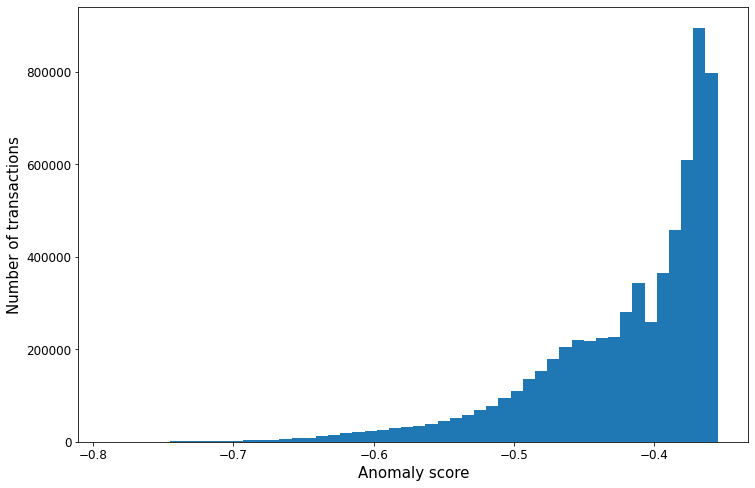

In [14]:
# plot anomaly score distribution
plt.hist(scores, bins=50)
plt.ylabel('Number of transactions', fontsize=15)
plt.xlabel('Anomaly score', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

A lower anomaly score means that there is a higher chance of that data point being an anomaly.

### Top n outliers

In [15]:
top_n_outliers = 5
top_n_outlier_indices = np.argpartition(scores, top_n_outliers)[:top_n_outliers].tolist()
top_outlier_entries = transactions.iloc[top_n_outlier_indices, :]
top_outlier_features = features.iloc[top_n_outlier_indices, :]
top_outlier_features

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,hour,changebalanceOrig,changebalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
4145988,31866120.39,503019.94,0.0,63539675.65,9.540580e+07,15,-503019.94,3.186612e+07,0,0,0,0,1
4155239,29642476.68,539407.79,0.0,53476069.02,8.311855e+07,15,-539407.79,2.964248e+07,0,0,0,0,1
4136960,29802113.19,550210.01,0.0,48574467.89,1.542623e+08,15,-550210.01,1.056878e+08,0,0,0,0,1
4157895,37387628.10,862621.88,0.0,37843025.59,7.523065e+07,15,-862621.88,3.738763e+07,0,0,0,0,1
4146715,38874009.46,435622.96,0.0,73634878.73,1.125089e+08,15,-435622.96,3.887401e+07,0,0,0,0,1


### ROC Evaluation

The raw output of the isolation forest is not a split of the dataset into anomalies and non-anomalies, but rather a list of continuous anomaly scores, one for every entry. This means that, depending on how many anomalies we want to detect (how wide we want to cast our net), we can set a different threshold which determines the data points that are considered as anomalies (i.e. data points with scores below the threshold). One way to evaluate the result of our model without choosing one particular thresholdis by computing the area under the ROC curve of the model output.

To have a baseline to compare the isolation forest to, we chose to evaluate a naive method for anomaly detection in this dataset which consists of treating the money amount transfered as anomaly score, where higher amounts represent a higher chance of being an anomaly. This approach (with a threshold of 200000) was taken to compute the 'isFlaggedFraud' column of the data set. We will take this approach without a fixed threshold to compute a naive ROC area under the curve.

Finally, we will also add the AUC score that would be obtained by random guessing.

The predicted anomalies are evaluated against the 'isFraud' columns which represents the ground truth value of whether the given entry constitutes an anomaly or not.

In [16]:
# evaluate isolation forest anomaly scores
fpr_iforest, tpr_iforest, thresholds_iforest = roc_curve(transactions['isFraud'], -scores)
auc_score_iforest = roc_auc_score(transactions['isFraud'], -scores)

# evaluate naive (amount) anomaly scores
fpr_naive, tpr_naive, thresholds_naive = roc_curve(transactions['isFraud'], transactions['amount'])
auc_score_naive = roc_auc_score(transactions['isFraud'], transactions['amount'])

In [17]:
def plot_roc_curve(fpr, tpr, name, auc_score):
    plt.plot(fpr, tpr, label=name + ', AUC={}'.format(round(auc_score, 3)))

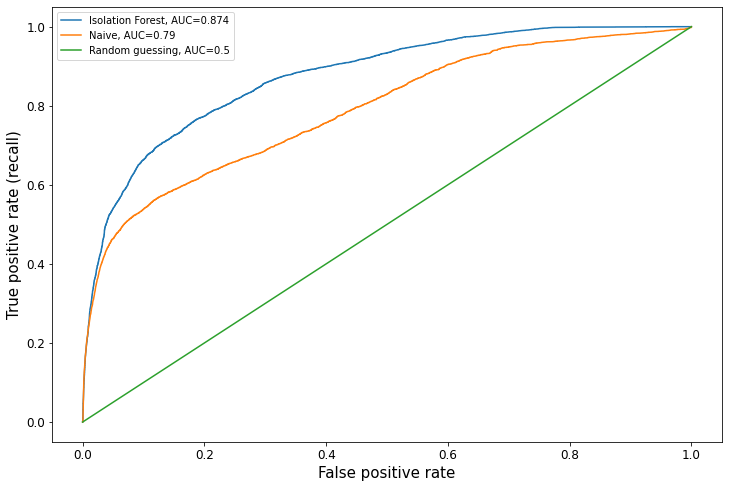

In [18]:
plot_roc_curve(fpr_iforest, tpr_iforest, 'Isolation Forest', auc_score_iforest)
plot_roc_curve(fpr_naive, tpr_naive, 'Naive', auc_score_naive)
plot_roc_curve([0, 1], [0, 1], 'Random guessing', 0.5)
plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate (recall)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(prop={'size': 12})
plt.legend()

This score is apparently 'excellent': https://www.sciencedirect.com/science/article/pii/S1556086415306043

### Explanation Model

In [19]:
n_random = 5000  # size of random sample
random_indices = np.random.choice(len(features), n_random)
explainer = shap.TreeExplainer(forest)
shap_values_random = explainer.shap_values(features.iloc[random_indices, :])
top_shap_values = explainer.shap_values(top_outlier_features)
random_features = features.iloc[random_indices, :]

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
The sklearn.ensemble.iforest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.


In [20]:
def condense(features, shap_values, indices):
    features_condensed = features.drop(columns=['CASH_IN', 'PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT'])
    features_condensed['type'] = transactions['type']
    selected_features_condensed = features_condensed.iloc[indices, :]
    
    shap_values_without_type = shap_values[:, :-5]
    shap_values_type_sum = shap_values[:, -5:].sum(axis=1).reshape(-1, 1)

    shap_values_condensed = np.concatenate([shap_values_without_type, shap_values_type_sum], axis=1)

    return selected_features_condensed, shap_values_condensed

Aggregate categorical 'type' features

In [21]:
random_features_condensed, shap_values_random_condensed = condense(features, shap_values_random, random_indices)
top_outlier_features_condensed, top_shap_values_condensed = condense(features, top_shap_values, top_n_outlier_indices)

SHAP summary plot

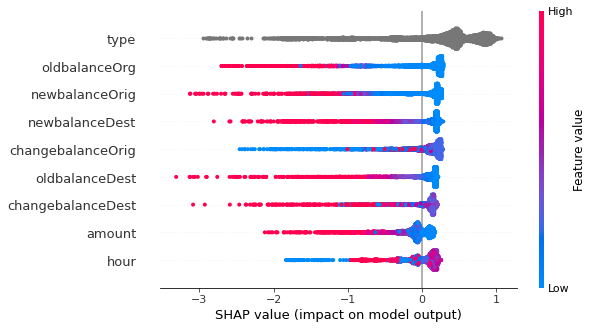

In [22]:
shap.summary_plot(shap_values_random_condensed, random_features_condensed)

SHAP dependence plots

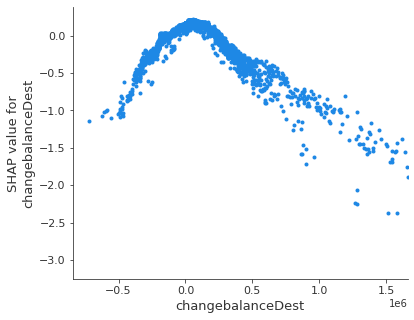

In [23]:
shap.dependence_plot(
    "changebalanceDest",
    shap_values_random,
    random_features,
    interaction_index=None,
    x_jitter=0.5,
    #xmin="percentile(0.5)",
    xmax="percentile(99)"
)

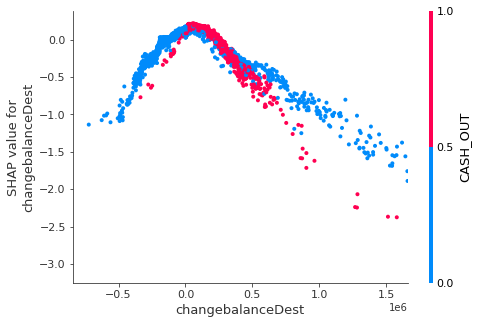

In [24]:
shap.dependence_plot(
    "changebalanceDest",
    shap_values_random,
    random_features,
    interaction_index='CASH_OUT',
    x_jitter=0.5,
    #xmin="percentile(0.5)",
    xmax="percentile(99)"
)

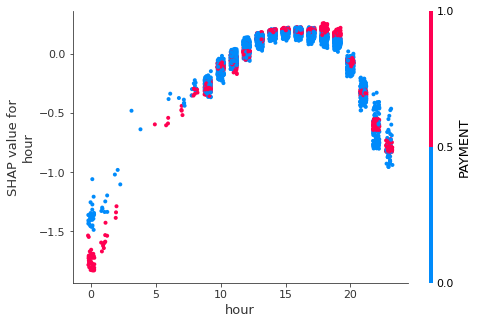

In [25]:
shap.dependence_plot(
    "hour",
    shap_values_random,
    random_features,
    interaction_index='auto',
    x_jitter=0.5,
    #xmin="percentile(1)",
    #xmax="percentile(99)"
)

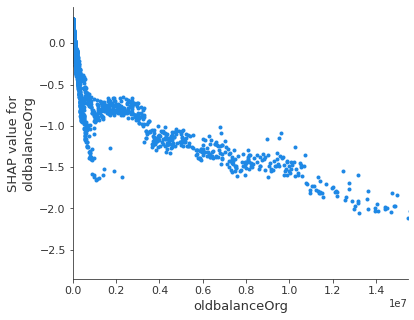

In [26]:
shap.dependence_plot(
    "oldbalanceOrg",
    shap_values_random_condensed,
    random_features_condensed,
    interaction_index=None,
    x_jitter=0.5,
    xmin="percentile(1)",
    xmax="percentile(99)"
)

Top n outlier explanations

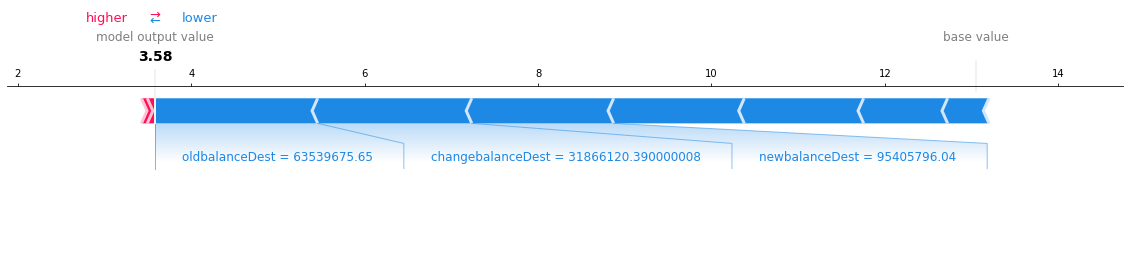

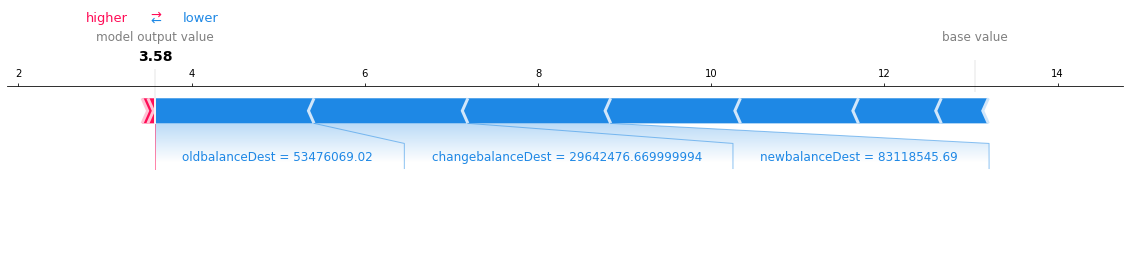

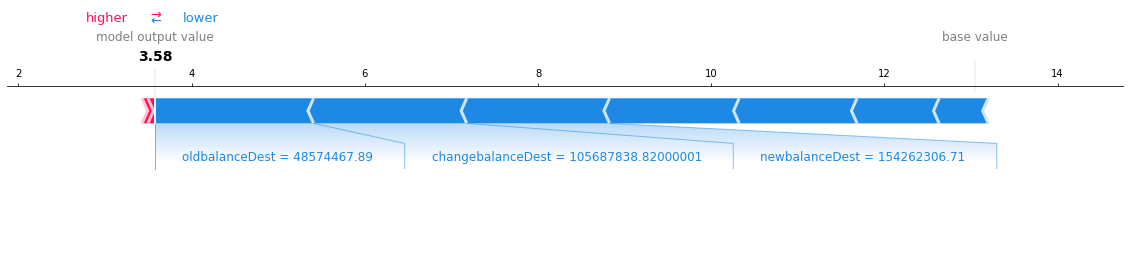

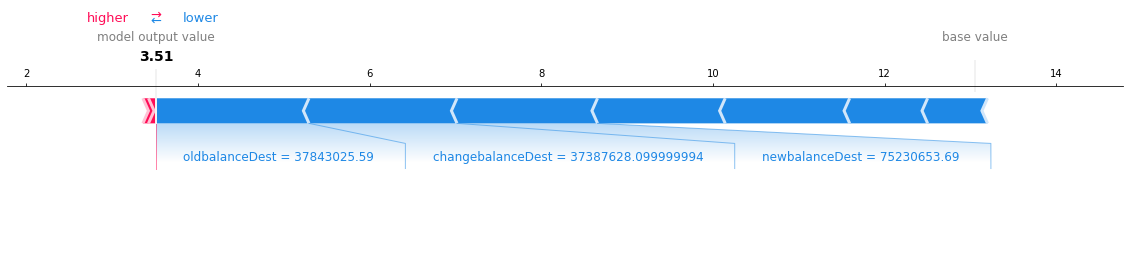

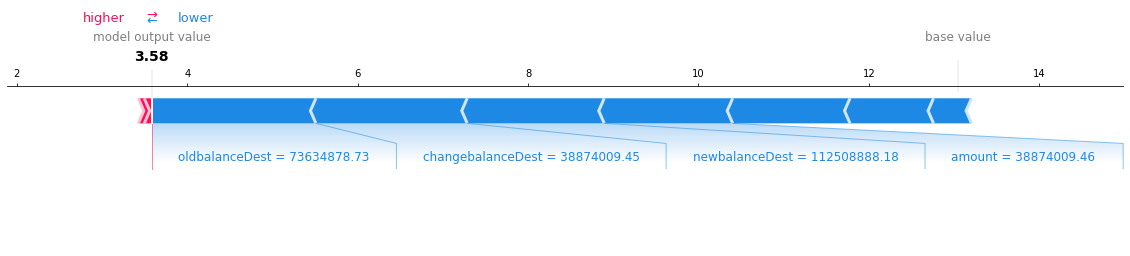

In [28]:
for index in range(top_n_outliers):
    shap.force_plot(explainer.expected_value, top_shap_values_condensed[index, :], top_outlier_features_condensed.iloc[index, :], show=False, matplotlib=True).savefig('scratch.png')